In [9]:
import json
import os
from collections import defaultdict
import traceback
from difflib import SequenceMatcher
import argparse

import fitz
from fitz import Rect
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom import minidom
# import editdistance
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json

In [5]:
image_folder_path = 'D:/process_scitsr_data/process_scitsr_data/table_image_saved/'
table_cells_path = 'D:/process_scitsr_data/process_scitsr_data/intermediate_table_cells/'

In [4]:
file_name = os.listdir(image_path)
len(file_name)

11986

In [75]:
test_file_name = file_name[47]    
image_path = image_folder_path + test_file_name
image = Image.open(image_path)
cell_path = table_cells_path + test_file_name[:-4] + '.json'  
with open(cell_path) as f:
    cell_data = json.load(f)

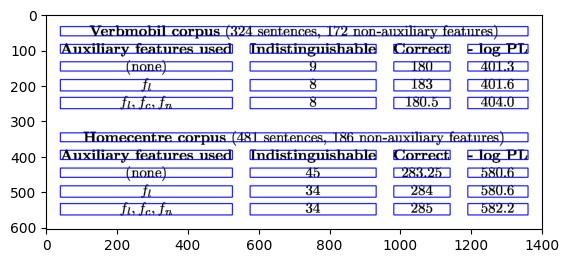

11 4


TypeError: 'int' object is not subscriptable

In [91]:
image_draw = cv2.imread(image_path)
for cell_detail in cell_data:
    coords = cell_detail['coordinates']
    if len(coords) == 4:
        cv2.rectangle(image_draw, (int(coords[0]), int(coords[1]-5)), (int(coords[2]), int(coords[3])), (0, 0, 255), thickness=2)
plt.imshow(image_draw)
plt.show()
num_rows = max([int(cell['end_row']) for cell in cell_data]) + 1
nun_cols = max([int(cell['end_col']) for cell in cell_data]) + 1   
print(num_rows, nun_cols)
h,w,c = np.array(image).shape
row_dict = {key : [] for key in range(num_rows)}
for cell_detail in cell_data:
    if cell_detail['start_row'] == cell_detail['end_row'] :
        idx_row = int(cell_detail['start_row'])
        row_dict[idx_row].append(cell_detail['coordinates'])
row_bbox_final = []
for row_element in row_dict:
    if len(row_element[0]) == 0:
        continue
    row_element = np.array(row_dict[row_element])
    y1_min = np.min(row_element[:,1])
    y2_max = np.max(row_element[:,3])
    
    x1 = 0
    x2 = w
    row_bbox_final.append([x1, y1_min, x2, y2_max])

In [90]:
len(row_dict[6][0])

4

In [77]:
cell_data

[{'cell_id': 0,
  'coordinates': [40, 40, 1361, 61],
  'content': 'Verbmobil corpus (324 sentences, 172 non-auxiliary features)',
  'start_row': 0,
  'end_row': 0,
  'start_col': 0,
  'end_col': 3},
 {'cell_id': 1,
  'coordinates': [40, 90, 526, 110],
  'content': 'Auxiliary features used',
  'start_row': 1,
  'end_row': 1,
  'start_col': 0,
  'end_col': 0},
 {'cell_id': 2,
  'coordinates': [576, 90, 932, 110],
  'content': 'Indistinguishable',
  'start_row': 1,
  'end_row': 1,
  'start_col': 1,
  'end_col': 1},
 {'cell_id': 3,
  'coordinates': [982, 90, 1141, 110],
  'content': 'Correct',
  'start_row': 1,
  'end_row': 1,
  'start_col': 2,
  'end_col': 2},
 {'cell_id': 4,
  'coordinates': [1191, 90, 1361, 110],
  'content': '- log PL',
  'start_row': 1,
  'end_row': 1,
  'start_col': 3,
  'end_col': 3},
 {'cell_id': 5,
  'coordinates': [40, 139, 526, 160],
  'content': '(none)',
  'start_row': 2,
  'end_row': 2,
  'start_col': 0,
  'end_col': 0},
 {'cell_id': 6,
  'coordinates': [576,

In [82]:
def get_row_bbox(num_rows, cell_data, image):
    h,w,c = np.array(image).shape
    row_dict = {key : [] for key in range(num_rows)}
    for cell_detail in cell_data:
        if cell_detail['start_row'] == cell_detail['end_row'] :
            idx_row = int(cell_detail['start_row'])
            row_dict[idx_row].append(cell_detail['coordinates'])
    row_bbox_final = []
    for row_element in row_dict:
        row_element = np.array(row_dict[row_element])
        if len(row_element) == 0:
            continue    
        try:
            y1_min = np.min(row_element[:,1]) - 5
        except:
            y1_min = np.min(row_element[:,1])
        y2_max = np.max(row_element[:,3])
        
        x1 = 0
        x2 = w
        row_bbox_final.append([x1, y1_min, x2, y2_max])   
    return row_bbox_final

In [83]:
def get_col_bbox(num_cols, cell_data, image):
    h,w,c = np.array(image).shape
    col_dict = {key : [] for key in range(num_cols)}
    for cell_detail in cell_data:
        if cell_detail['start_col'] == cell_detail['end_col'] :
            idx_col = int(cell_detail['start_col'])
            col_dict[idx_col].append(cell_detail['coordinates'])
    col_bbox_final = []
    for col_element in col_dict:
        if len(col_dict[col_element]) == 0:
            continue
        col_element = np.array(col_dict[col_element])
        x1_min = np.min(col_element[:,0])
        x2_max = np.max(col_element[:,2])
        
        y1 = 0
        y2 = h
        col_bbox_final.append([x1_min, y1, x2_max, y2])   
    return col_bbox_final

In [50]:
def get_row_binary(row_bbox_final, image):
    h,w,c = np.array(image).shape
    row_image = np.zeros(shape = (h,w))
    row_1d = np.zeros(shape = (h,), dtype = np.uint8)

    for row_bbox in row_bbox_final:
        x1 = row_bbox[0]
        y1 = row_bbox[1]
        x2 = row_bbox[2]
        y2 = row_bbox[3]
        row_image[y1:y2, x1:x2] = 1
        row_1d[y1:y2] = 1
    return row_image, row_1d

In [51]:
def get_col_binary(col_bbox_final, image):
    h,w,c = np.array(image).shape
    col_image = np.zeros(shape = (h,w))
    col_1d = np.zeros(shape =(w,),dtype =  np.uint8)

    for col_bbox in col_bbox_final:
        x1 = col_bbox[0]
        y1 = col_bbox[1]
        x2 = col_bbox[2]
        y2 = col_bbox[3]
        col_image[y1:y2, x1:x2] = 1
        col_1d[x1:x2] = 1
    return col_image, col_1d

In [58]:
def make_image_row(row, image):
    h,w,c = np.array(image).shape
    img_row = np.zeros((h, w), dtype=np.uint8)  
    mask_img_row = np.where(row ==1 )
    img_row[mask_img_row,:] = 1
    # img_row = cv2.resize(img_row, new_shape)
    img_row  = np.array(img_row)
    return img_row

In [57]:
def make_image_col(col, image):
    h,w,c = np.array(image).shape
    img_col = np.zeros((h, w), dtype=np.uint8)  
    mask_img_col = np.where(col ==1 )
    img_col[:,mask_img_col] = 1
    # img_col = cv2.resize(img_col, new_shape)
    img_col  = np.array(img_col)
    return img_col

In [74]:
test_file_name = file_name[47]    
image_path = image_folder_path + test_file_name
image = Image.open(image_path)
image_np = np.array(image)
cell_path = table_cells_path + test_file_name[:-4] + '.json'  
with open(cell_path) as f:
    cell_data = json.load(f)

# plt.imshow(image_np)
# plt.show()

row_bbox_ = get_row_bbox(num_rows, cell_data, image_np)
col_bbox_ = get_col_bbox(nun_cols, cell_data, image_np)
# row_image, row_1d = get_row_binary(row_bbox_, image_np)
# col_image, col_1d = get_col_binary(col_bbox_, image_np)

# image_row_ = make_image_row(row_1d, image_np)
# image_col_ = make_image_col(col_1d, image_np)
# fig, ax = plt.subplots(1,3, figsize=(25, 25))
# ax[0].imshow(image_col_)
# ax[1].imshow(image_np)
# ax[2].imshow(image_row_)

IndexError: index 1 is out of bounds for axis 1 with size 0

In [84]:
data_frame = {}
file_name_list = os.listdir(image_folder_path)
for idx in range(len(file_name_list)):
    print(idx)
    file_name_member = file_name_list[idx]
    image_path = image_folder_path + file_name_member
    image = Image.open(image_path)
    image_np = np.array(image)
    cell_path = table_cells_path + file_name_member[:-4] + '.json'  
    with open(cell_path) as f:
        cell_data = json.load(f)
    num_rows = max([int(cell['end_row']) for cell in cell_data]) + 1
    nun_cols = max([int(cell['end_col']) for cell in cell_data]) + 1
    row_bbox_ = get_row_bbox(num_rows, cell_data, image_np)
    col_bbox_ = get_col_bbox(nun_cols, cell_data, image_np)
    row_image, row_1d = get_row_binary(row_bbox_, image_np)
    col_image, col_1d = get_col_binary(col_bbox_, image_np)

    file_name_save = file_name_member[:-4]
    data_binary = [row_1d.tolist(), col_1d.tolist()]
    update = {file_name_save: data_binary}
    data_frame.update(**update)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


IndexError: index 1 is out of bounds for axis 1 with size 0

In [47]:
# h,w,c = np.array(image).shape
# col_dict = {key : [] for key in range(nun_cols)}
# for cell_detail in cell_data:
#     if cell_detail['start_col'] == cell_detail['end_col'] :
#         idx_col = int(cell_detail['start_col'])
#         col_dict[idx_col].append(cell_detail['coordinates'])
# col_bbox_final = []
# for col_element in col_dict:
#     col_element = np.array(col_dict[col_element])
#     x1_min = np.min(col_element[:,0])
#     x2_max = np.max(col_element[:,2])
    
#     y1 = 0
#     y2 = h
#     col_bbox_final.append([x1_min, y1, x2_max, y2])

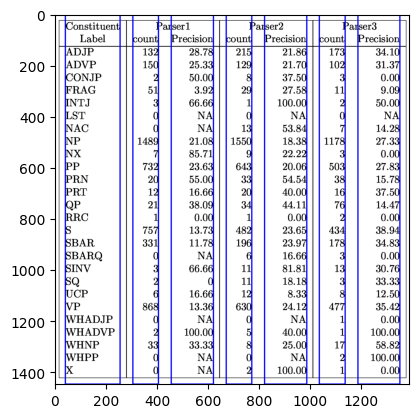

In [45]:
image_draw = cv2.imread(image_path)
for bbox in col_bbox_final:
    cv2.rectangle(image_draw, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), thickness=3)
plt.imshow(image_draw)
plt.show()